# Set up

In [1]:
# Basic imports
import os
import math
import importlib
import random
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

# Machine learning imports
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Financial imports
import yfinance as yf
import pandas_datareader as pdr

# Self Packages
import data
importlib.reload(data)
from data import load_data

# Setting random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Data & Feature Generation

## Data Preparation

In [ ]:
# Data Preparation
def prepare_data(df, features = ["Price"]):
    """
    Purpose:
    Prepares the input DataFrame for time series modeling by selecting relevant columns and normalizing their values.
    - Column Selection: Extracts only the columns specified in the features list (default is just "Price").
    - Missing Value Handling: Drops any rows with missing values in the selected features.
    - Normalization: Scales each selected column to the range [0, 1] using MinMaxScaler from sklearn.preprocessing.
    - Stores Scalers: Keeps a dictionary of the scalers used for each column so the normalization can be reversed later if needed.
    
    Returns:
        data: Normalized data as a pandas DataFrame.
        scaler_dict: Dictionary mapping each feature to its corresponding MinMaxScaler.
        features: The list of features used (same as input).

    """
    # Select the relevant columns
    data = df[features].copy().dropna()

    # Normalise the data
    scaler_dict = {}
    for column in data.columns:
        scaler = MinMaxScaler()
        data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1))
        scaler_dict[column] = scaler
    
    return data, scaler_dict, features

# Create sequences
def create_sequences(data, seq_length, target_column='Price'):
    """
    Transforms the normalized time series data into input-output sequences for supervised learning.

    Parameters:
    - data (pd.DataFrame): The normalized data to be transformed.
    - seq_length (int): The length of each input sequence.
    - target_column (str): The name of the target column. Default is 'Price'.

    Returns:
    - xs (np.ndarray): Array of input sequences with shape (num_sequences, seq_length, num_features).
    - ys (np.ndarray): Array of target values corresponding to each input sequence.
    
    Steps:
    1. Iterates through the data to build sequences of length `seq_length`.
    2. Each sequence is paired with the target value that follows it in the time series.
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length][target_column]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Model Architecture

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    """
    Implements sinusoidal positional encoding as described in the Transformer architecture.

    Attributes:
    - d_model (int): Dimensionality of the model.
    - pos_encoding (tf.Tensor): Precomputed positional encodings of shape [1, max_seq_length, d_model].

    Methods:
    - call(inputs): Adds positional encoding to the input tensor.
    """
    def __init__(self, d_model, max_seq_length=1000):
        super().__init__()
        
        # Create positional encodings
        pos = np.arange(max_seq_length)[:, np.newaxis]  # Shape: [max_seq_length, 1]
        i = np.arange(d_model)[np.newaxis, :]  # Shape: [1, d_model]

        # Compute the angular frequencies
        div_term = np.exp(-np.log(10000.0) * (2 * (i // 2) / d_model))

        # Apply sine to even indices and cosine to odd indices
        pos_encoding = np.zeros((max_seq_length, d_model))
        pos_encoding[:, 0::2] = np.sin(pos * div_term[:, 0::2])  # Even indices
        pos_encoding[:, 1::2] = np.cos(pos * div_term[:, 1::2])  # Odd indices

        self.pos_encoding = tf.cast(pos_encoding[np.newaxis, :, :], tf.float32)  # Add batch dimension: [1, max_seq_len, d_model]
        self.d_model = d_model

    def call(self, inputs):
        """
        Adds positional encoding to the input tensor.
        """
        seq_length = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_length, :]

class TransformerEncoderLayer(tf.keras.layers.Layer):
    """
    Implements a single Transformer encoder layer with multi-head attention, 
    feed-forward network, and attention decay regularization.

    Attributes:
    - mha (tf.keras.layers.MultiHeadAttention): Multi-head attention mechanism.
    - ffn (tf.keras.Sequential): Feed-forward neural network.
    - layernorm1, layernorm2 (tf.keras.layers.LayerNormalization): Layer normalization layers.
    - dropout1, dropout2 (tf.keras.layers.Dropout): Dropout layers.
    - attention_decay_factor (float): Regularization strength for penalizing attention to distant positions.
    - attention_weights (tf.Tensor): Stores attention weights for interpretability.
    
    Methods:
    - call(inputs, training, mask): Applies the transformer encoder operations to the input.
    """
    def __init__(self, d_model, num_heads, dropout_rate=0.1, attention_decay_factor=0.01, ff_dim=None):
        super().__init__()
        if ff_dim is None:
            ff_dim = 4 * d_model
        
        self.attention_decay_factor = attention_decay_factor

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model//num_heads)
        
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
            tf.keras.layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(l2=0.01))
        ])
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        
        # Store attention weights
        self.attention_weights = None
        
    def call(self, inputs, training=None, mask=None):
        """
        Applies multi-head attention, attention decay penalty, feed-forward network, and layer normalization.
        """
        # Multi-head attention with residual connection and layer normalization
        attn_output, attention_weights = self.mha(
            inputs, inputs, 
            return_attention_scores=True,
            attention_mask=mask
        )
        
        # Store attention weights for later analysis
        self.attention_weights = attention_weights

        # Add attention decay regularization calculation
        if training:
            seq_length = tf.shape(attention_weights)[-1]
        
            # Create position indices
            positions = tf.range(seq_length, dtype=tf.float32)
            
            # Calculate distance matrix (how far each position is from other positions)
            pos_i = tf.expand_dims(positions, 0)  # [1, seq_len]
            pos_j = tf.expand_dims(positions, 1)  # [seq_len, 1]
            distance_matrix = tf.abs(pos_i - pos_j)  # [seq_len, seq_len]
            
            # Create decay mask - HIGHER weights for DISTANT positions
            decay_mask = 1.0 - tf.exp(-self.attention_decay_factor * distance_matrix)
            
            # Average attention across batch and heads
            avg_attention = tf.reduce_mean(attention_weights, axis=[0, 1])
            
            # Calculate penalty - higher when distant positions get low attention
            recency_penalty = tf.reduce_sum(avg_attention * decay_mask) 
            
            self.add_loss(self.attention_decay_factor * recency_penalty)
        
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        # Feed-forward network with residual connection and layer normalization
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class GoldPriceTransformer(tf.keras.Model):
    """
    Transformer-based model for forecasting time series data, such as gold prices.

    Attributes:
    - input_projection (Dense): Projects input features to the transformer dimension.
    - positional_encoding (PositionalEncoding): Adds positional context to input sequences.
    - encoder_layers (list of TransformerEncoderLayer): Stacked transformer encoder layers.
    - dropout (Dropout): Dropout layer applied after positional encoding.
    - output_projection (Dense): Final projection layer to the target output dimension.

    Methods:
    - call(inputs, training, mask): Forward pass of the transformer model.
    """
    def __init__(self, input_dim, output_dim, d_model=128, num_heads=8, 
                 num_layers=3, dropout_rate=0.1, attention_decay_factor=0.01):
        super().__init__()
        
        self.input_projection = tf.keras.layers.Dense(d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        
        self.encoder_layers = [
            TransformerEncoderLayer(
                d_model, 
                num_heads, 
                dropout_rate, 
                attention_decay_factor=attention_decay_factor
            )
            for _ in range(num_layers)
        ]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.output_projection = tf.keras.layers.Dense(output_dim)
        
    def call(self, inputs, training=None, mask=None):
        """
        Runs the full forward pass of the model.
        """
        # Inputs shape: [batch_size, seq_len, input_dim]
        x = self.input_projection(inputs)
        x = self.positional_encoding(x)
        x = self.dropout(x, training=training)
        
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, training=training, mask=mask)
            
        # Extract the last time step for forecasting
        final_output = x[:, -1, :]
        return self.output_projection(final_output)


# Analysis

In [ ]:
# Feature Importance Analysis
def analyze_feature_importance(model, X_test, y_test, price_scaler, feature_names, 
                              batch_size=None, 
                              n_repeats=5,
                              normalize=True,
                              show_plot=True,
                              figure_size=(12, 6),
                              sort_features=False):
    """
    Analyze feature importance using timestep-aware permutation for sequential models.
    """
    import numpy as np
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    
    # Get baseline predictions and baseline MSE
    baseline_preds = model.predict(X_test, batch_size=batch_size, verbose=0)
    baseline_mse = mean_squared_error(y_test, baseline_preds)
    
    # Initialize arrays to store results
    n_features = X_test.shape[2]
    importances = np.zeros((n_repeats, n_features))
    
    # For each feature
    for i in range(n_features):
        # For each repetition
        for r in range(n_repeats):
            # Create a copy of the test data
            X_permuted = X_test.copy()
            
            # Permute feature values per timestep to maintain sequential structure
            for t in range(X_permuted.shape[1]):  # Loop over timesteps
                X_permuted[:, t, i] = np.random.permutation(X_permuted[:, t, i])
            
            # Get predictions with permuted feature
            permuted_preds = model.predict(X_permuted, batch_size=batch_size, verbose=0)
            permuted_mse = mean_squared_error(y_test, permuted_preds)
            
            # Calculate importance: how much the performance drops due to permutation
            # Higher value = more important feature
            importances[r, i] = permuted_mse - baseline_mse
    
    # Calculate mean and std of importance scores across repetitions
    mean_importances = np.mean(importances, axis=0)
    std_importances = np.std(importances, axis=0)
    
    # Force non-negative importance values (some might be negative due to randomness)
    mean_importances = np.maximum(0, mean_importances)
    
    # Normalize if requested and possible
    if normalize and np.sum(mean_importances) > 0:
        mean_importances = mean_importances / np.sum(mean_importances)
    
    # Prepare data for plotting
    if sort_features:
        # Sort features by importance
        sorted_idx = np.argsort(mean_importances)[::-1]  # Descending order
        plot_features = [feature_names[i] for i in sorted_idx]
        plot_importances = mean_importances[sorted_idx]
        plot_stds = std_importances[sorted_idx]
    else:
        plot_features = feature_names
        plot_importances = mean_importances
        plot_stds = std_importances
    
    # Plot feature importance
    if show_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figure_size)

        # Plot predictions (last 100)
        ax1.plot(price_scaler.inverse_transform(y_test[-100:].reshape(-1, 1)), label="True", color="blue")
        ax1.plot(price_scaler.inverse_transform(baseline_preds[-100:]), label="Predicted", color="red")
        ax1.set_title("Last 100 Predictions vs True Values")
        ax1.set_xlabel("Time Step")
        ax1.set_ylabel("Value")
        ax1.legend()
        ax1.grid(True)

        # Plot feature importances
        bars = ax2.bar(range(len(plot_features)), plot_importances, yerr=plot_stds,
                       align='center', alpha=0.8, ecolor='black', capsize=5)
        ax2.set_xlabel("Features")
        ax2.set_ylabel("Relative Importance")
        ax2.set_title("Feature Importance (Timestep-Aware Permutation)")
        ax2.set_xticks(range(len(plot_features)))
        ax2.set_xticklabels(plot_features, rotation=45, ha='right')

        # Add text labels on bars
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
                     f'{height:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()
    
    # Return results as a dictionary
    results = {
        'mean_importance': dict(zip(feature_names, mean_importances)),
        'std_importance': dict(zip(feature_names, std_importances)),
        'baseline_error': baseline_mse,
        'method': 'timestep_aware'
    }
    
    return results

def visualize_time_attention(model, X_sample):
    """
    Visualize which time steps the model is paying most attention to
    """
    # We need to run a forward pass to get attention weights
    _ = model(tf.convert_to_tensor(X_sample[np.newaxis, ...], dtype=tf.float32))
    
    # Extract attention weights from the last layer
    attention_weights = model.encoder_layers[-1].attention_weights
    
    # Average across heads to get one weight per timestep
    # Shape will be [batch, seq_len, seq_len]
    avg_weights = tf.reduce_mean(attention_weights, axis=1)[0]
    
    # The last row shows how much attention the prediction (last timestep) 
    # pays to each input timestep
    last_timestep_weights = avg_weights[-1, :].numpy()
    
    # Plot attention over time
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(last_timestep_weights)), last_timestep_weights)
    plt.xlabel('Time Step')
    plt.ylabel('Attention Weight')
    plt.title('Attention Distribution Across Time Steps')
    
    # Add marker for significant time points
    plt.axhline(y=np.mean(last_timestep_weights), color='r', linestyle='--', 
                label='Average Attention')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Also create a heatmap for all timesteps
    plt.figure(figsize=(10, 8))
    plt.imshow(avg_weights, cmap='viridis')
    plt.colorbar()
    plt.xlabel('Input Time Step')
    plt.ylabel('Output Time Step')
    plt.title('Full Attention Matrix')
    plt.tight_layout()
    plt.show()
    
    return last_timestep_weights

# Evaluation

In [ ]:
def backtest_trading_strategy(y_true, y_pred, initial_capital=10000):
    """
    Simple backtest of a trading strategy based on predictions
    """
    capital = initial_capital
    position = 0  # 0: no position, 1: long
    trades = []
    equity_curve = [capital]
    
    for i in range(1, len(y_true)):
        # Strategy: Buy if prediction is up, sell if prediction is down
        pred_direction = y_pred[i] > y_pred[i-1]
        
        # Execute trades
        if pred_direction and position == 0:  # Buy signal
            position = 1
            entry_price = y_true[i]
            trades.append(('BUY', i, entry_price))
        elif not pred_direction and position == 1:  # Sell signal
            position = 0
            exit_price = y_true[i]
            profit = exit_price - trades[-1][2]  # Current price - entry price
            capital += profit * (initial_capital / trades[-1][2])  # Scale by position size
            trades.append(('SELL', i, exit_price, profit))
        
        # Update equity curve
        if position == 1:
            # If holding, update equity with unrealized gains/losses
            current_value = capital + (y_true[i] - trades[-1][2]) * (initial_capital / trades[-1][2])
            equity_curve.append(current_value)
        else:
            equity_curve.append(capital)
    
    # Calculate performance metrics
    returns = (capital - initial_capital) / initial_capital * 100
    
    # Calculate Sharpe ratio (simplified)
    daily_returns = np.diff(equity_curve) / np.array(equity_curve[:-1])
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Annualized
    
    # Plot equity curve
    plt.figure(figsize=(14, 7))
    plt.plot(equity_curve)
    plt.xlabel('Time')
    plt.ylabel('Capital')
    plt.title(f'Equity Curve (Return: {returns:.2f}%, Sharpe: {sharpe_ratio:.2f})')
    plt.grid(True)
    plt.show()
    
    print(f"Final capital: ${capital:.2f}")
    print(f"Return: {returns:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Number of trades: {len(trades) // 2}")
    
    return trades, equity_curve

# Main Backtesting Process
def run_gold_price_backtesting(df, features, seq_length=60, test_size=0.2, 
                              d_model=64, num_heads=4, num_layers=2, 
                              dropout_rate=0.1, batch_size=32, epochs=50,
                              attention_decay_factor=0.01):
    """
    Complete backtesting process for gold price prediction
    """
    # Split raw data first
    train_size = int(len(df) * (1 - test_size))
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size - seq_length:]

    # Prepare training data
    if "Price" not in features:
        features.append("Price")
    train_data, scaler_dict, features = prepare_data(train_data, features)
    price_scaler = scaler_dict['Price']

    # Apply the same scalers to test data
    test_data_scaled = test_data[features].copy()
    for column in test_data_scaled.columns:
        test_data_scaled[column] = scaler_dict[column].transform(
            test_data_scaled[column].values.reshape(-1, 1)
        )

    # Create sequences for both sets
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data_scaled, seq_length)
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    
    # Initialize the model
    input_dim = X_train.shape[2]
    output_dim = 1
    
    model = GoldPriceTransformer(
        input_dim=input_dim,
        output_dim=output_dim,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        attention_decay_factor=attention_decay_factor
    )
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.002159445661675262),
        loss="mean_squared_error",
    )
    
    # Define callbacks
    callbacks = []
    
    # Add early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    callbacks.append(early_stopping)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test)
    
    # Denormalize predictions and actual values
    y_test_denorm = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_denorm = price_scaler.inverse_transform(y_pred).flatten()
    
    # Calculate performance metrics
    mse = mean_squared_error(y_test_denorm, y_pred_denorm)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
    r2 = r2_score(y_test_denorm, y_pred_denorm)

    non_zero_indices = y_test_denorm != 0
    mape = np.mean(np.abs((y_test_denorm[non_zero_indices] - y_pred_denorm[non_zero_indices]) / y_test_denorm[non_zero_indices])) * 100

    
    print(f"Test MSE: {mse:.2f}")
    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test MAE: {mae:.2f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Test R²: {r2:.4f}")
    
    # Calculate directional accuracy
    def directional_accuracy(y_true, y_pred):
        y_true_changes = np.diff(y_true)
        y_pred_changes = np.diff(y_pred)
        correct_direction = (y_true_changes * y_pred_changes) > 0
        return np.mean(correct_direction) * 100
    
    da = directional_accuracy(y_test_denorm, y_pred_denorm)
    print(f"Directional Accuracy: {da:.2f}%")
    
    # Plot results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(y_test_denorm[-100:], label='Actual', color='blue')
    plt.plot(y_pred_denorm[-100:], label='Predicted', color='red')
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel('Gold Price')
    plt.title('Last 100 Predictions')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Time attention visualization
    print("\nVisualizing attention over time...")
    time_attention = visualize_time_attention(model, X_test[0])
    
    # Trading strategy backtest
    print("\nRunning trading strategy backtest...")
    trades, equity_curve = backtest_trading_strategy(y_test_denorm, y_pred_denorm)
    
    # Return everything for further analysis
    results = {
        'model': model,
        'features': features,
        'history': history,
        'y_test': y_test_denorm,
        'y_pred': y_pred_denorm,
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'directional_accuracy': da
        },
        'time_attention': time_attention,
        'trading_results': {
            'trades': trades,
            'equity_curve': equity_curve
        }
    }
    
    return results

# Hyperparameter Tuning

[I 2025-04-24 10:37:40,807] A new study created in memory with name: no-name-7fdad84e-8e59-478a-9d9a-f69f8a1c3f6e
[I 2025-04-24 10:39:36,727] Trial 0 finished with value: 0.025297537446022034 and parameters: {'d_model': 128, 'num_heads': 2, 'num_layers': 4, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.0001, 'batch_size': 64, 'learning_rate': 0.0029343326386878864}. Best is trial 0 with value: 0.025297537446022034.



Trial 0 finished:
  Value: 0.0253
  Params: {'d_model': 128, 'num_heads': 2, 'num_layers': 4, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.0001, 'batch_size': 64, 'learning_rate': 0.0029343326386878864}
  This is the best trial so far!
  Best value: 0.0253
  Best params: {'d_model': 128, 'num_heads': 2, 'num_layers': 4, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.0001, 'batch_size': 64, 'learning_rate': 0.0029343326386878864}



[I 2025-04-24 10:41:24,816] Trial 1 finished with value: 0.0007754905382171273 and parameters: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}. Best is trial 1 with value: 0.0007754905382171273.



Trial 1 finished:
  Value: 0.0008
  Params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}
  This is the best trial so far!
  Best value: 0.0008
  Best params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}



[I 2025-04-24 10:44:13,262] Trial 2 finished with value: 0.009820163249969482 and parameters: {'d_model': 128, 'num_heads': 2, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0005, 'batch_size': 32, 'learning_rate': 0.0016329858479378198}. Best is trial 1 with value: 0.0007754905382171273.



Trial 2 finished:
  Value: 0.0098
  Params: {'d_model': 128, 'num_heads': 2, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0005, 'batch_size': 32, 'learning_rate': 0.0016329858479378198}
  Best value: 0.0008
  Best params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}



[I 2025-04-24 10:45:47,750] Trial 3 finished with value: 0.01684793084859848 and parameters: {'d_model': 256, 'num_heads': 4, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.0004, 'batch_size': 32, 'learning_rate': 0.0015697791437482467}. Best is trial 1 with value: 0.0007754905382171273.



Trial 3 finished:
  Value: 0.0168
  Params: {'d_model': 256, 'num_heads': 4, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.0004, 'batch_size': 32, 'learning_rate': 0.0015697791437482467}
  Best value: 0.0008
  Best params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}



[I 2025-04-24 10:47:04,165] Trial 4 finished with value: 0.039676472544670105 and parameters: {'d_model': 64, 'num_heads': 2, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.0004, 'batch_size': 64, 'learning_rate': 0.0016279408699360234}. Best is trial 1 with value: 0.0007754905382171273.



Trial 4 finished:
  Value: 0.0397
  Params: {'d_model': 64, 'num_heads': 2, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.0004, 'batch_size': 64, 'learning_rate': 0.0016279408699360234}
  Best value: 0.0008
  Best params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}



[I 2025-04-24 10:48:27,320] Trial 5 finished with value: 0.46663105487823486 and parameters: {'d_model': 256, 'num_heads': 8, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.0004, 'batch_size': 64, 'learning_rate': 0.0010892189463091134}. Best is trial 1 with value: 0.0007754905382171273.



Trial 5 finished:
  Value: 0.4666
  Params: {'d_model': 256, 'num_heads': 8, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.0004, 'batch_size': 64, 'learning_rate': 0.0010892189463091134}
  Best value: 0.0008
  Best params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}



[I 2025-04-24 10:51:34,245] Trial 6 finished with value: 0.02074454165995121 and parameters: {'d_model': 256, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.0005, 'batch_size': 32, 'learning_rate': 0.0013152605527634563}. Best is trial 1 with value: 0.0007754905382171273.



Trial 6 finished:
  Value: 0.0207
  Params: {'d_model': 256, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.0005, 'batch_size': 32, 'learning_rate': 0.0013152605527634563}
  Best value: 0.0008
  Best params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}



[I 2025-04-24 10:52:55,162] Trial 7 finished with value: 0.05294166877865791 and parameters: {'d_model': 256, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0001, 'batch_size': 64, 'learning_rate': 0.003097185440425726}. Best is trial 1 with value: 0.0007754905382171273.



Trial 7 finished:
  Value: 0.0529
  Params: {'d_model': 256, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0001, 'batch_size': 64, 'learning_rate': 0.003097185440425726}
  Best value: 0.0008
  Best params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}



[I 2025-04-24 10:54:14,624] Trial 8 finished with value: 0.03452394902706146 and parameters: {'d_model': 64, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.0005, 'batch_size': 64, 'learning_rate': 0.0013734284757320728}. Best is trial 1 with value: 0.0007754905382171273.



Trial 8 finished:
  Value: 0.0345
  Params: {'d_model': 64, 'num_heads': 6, 'num_layers': 3, 'dropout_rate': 0.4, 'attention_decay_factor': 0.0005, 'batch_size': 64, 'learning_rate': 0.0013734284757320728}
  Best value: 0.0008
  Best params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}



[I 2025-04-24 10:55:13,249] Trial 9 finished with value: 0.04571549966931343 and parameters: {'d_model': 256, 'num_heads': 2, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.0004, 'batch_size': 64, 'learning_rate': 0.002810664424662242}. Best is trial 1 with value: 0.0007754905382171273.



Trial 9 finished:
  Value: 0.0457
  Params: {'d_model': 256, 'num_heads': 2, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.0004, 'batch_size': 64, 'learning_rate': 0.002810664424662242}
  Best value: 0.0008
  Best params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}



[I 2025-04-24 10:56:31,689] Trial 10 finished with value: 0.004897559992969036 and parameters: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.004836953933609443}. Best is trial 1 with value: 0.0007754905382171273.



Trial 10 finished:
  Value: 0.0049
  Params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.004836953933609443}
  Best value: 0.0008
  Best params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}



[I 2025-04-24 10:57:48,244] Trial 11 finished with value: 0.006358860991895199 and parameters: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.004868664796026358}. Best is trial 1 with value: 0.0007754905382171273.



Trial 11 finished:
  Value: 0.0064
  Params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.004868664796026358}
  Best value: 0.0008
  Best params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}



[I 2025-04-24 10:58:58,199] Trial 12 finished with value: 0.008005741983652115 and parameters: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.004657155944745242}. Best is trial 1 with value: 0.0007754905382171273.



Trial 12 finished:
  Value: 0.0080
  Params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.004657155944745242}
  Best value: 0.0008
  Best params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}



[I 2025-04-24 11:00:34,124] Trial 13 finished with value: 0.0018374791834503412 and parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.003913621765783855}. Best is trial 1 with value: 0.0007754905382171273.



Trial 13 finished:
  Value: 0.0018
  Params: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.003913621765783855}
  Best value: 0.0008
  Best params: {'d_model': 128, 'num_heads': 8, 'num_layers': 2, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.004080146800589025}



[I 2025-04-24 11:02:19,174] Trial 14 finished with value: 0.00036817946238443255 and parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0036988065353288405}. Best is trial 14 with value: 0.00036817946238443255.



Trial 14 finished:
  Value: 0.0004
  Params: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0036988065353288405}
  This is the best trial so far!
  Best value: 0.0004
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0036988065353288405}



[I 2025-04-24 11:04:04,945] Trial 15 finished with value: 0.005511359311640263 and parameters: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0022310255776837426}. Best is trial 14 with value: 0.00036817946238443255.



Trial 15 finished:
  Value: 0.0055
  Params: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0022310255776837426}
  Best value: 0.0004
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0036988065353288405}



[I 2025-04-24 11:05:38,677] Trial 16 finished with value: 0.002110908040776849 and parameters: {'d_model': 128, 'num_heads': 4, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0038513546565278026}. Best is trial 14 with value: 0.00036817946238443255.



Trial 16 finished:
  Value: 0.0021
  Params: {'d_model': 128, 'num_heads': 4, 'num_layers': 2, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0038513546565278026}
  Best value: 0.0004
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0036988065353288405}



[I 2025-04-24 11:08:51,981] Trial 17 finished with value: 0.00041013810550794005 and parameters: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.002305827777797123}. Best is trial 14 with value: 0.00036817946238443255.



Trial 17 finished:
  Value: 0.0004
  Params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.002305827777797123}
  Best value: 0.0004
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0036988065353288405}



[I 2025-04-24 11:11:38,550] Trial 18 finished with value: 0.0012157269520685077 and parameters: {'d_model': 64, 'num_heads': 6, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.00203419047374683}. Best is trial 14 with value: 0.00036817946238443255.



Trial 18 finished:
  Value: 0.0012
  Params: {'d_model': 64, 'num_heads': 6, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.00203419047374683}
  Best value: 0.0004
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0036988065353288405}



[I 2025-04-24 11:14:11,993] Trial 19 finished with value: 0.0006409295601770282 and parameters: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.002553704544194713}. Best is trial 14 with value: 0.00036817946238443255.



Trial 19 finished:
  Value: 0.0006
  Params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.002553704544194713}
  Best value: 0.0004
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0036988065353288405}



[I 2025-04-24 11:16:58,830] Trial 20 finished with value: 0.0006789971375837922 and parameters: {'d_model': 64, 'num_heads': 6, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0001, 'batch_size': 32, 'learning_rate': 0.003294460690560567}. Best is trial 14 with value: 0.00036817946238443255.



Trial 20 finished:
  Value: 0.0007
  Params: {'d_model': 64, 'num_heads': 6, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0001, 'batch_size': 32, 'learning_rate': 0.003294460690560567}
  Best value: 0.0004
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0036988065353288405}



[I 2025-04-24 11:20:05,728] Trial 21 finished with value: 0.0005429824814200401 and parameters: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.0024846082954625964}. Best is trial 14 with value: 0.00036817946238443255.



Trial 21 finished:
  Value: 0.0005
  Params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.0024846082954625964}
  Best value: 0.0004
  Best params: {'d_model': 128, 'num_heads': 6, 'num_layers': 2, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0036988065353288405}



[I 2025-04-24 11:23:42,139] Trial 22 finished with value: 0.0003196604666300118 and parameters: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.002159445661675262}. Best is trial 22 with value: 0.0003196604666300118.



Trial 22 finished:
  Value: 0.0003
  Params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.002159445661675262}
  This is the best trial so far!
  Best value: 0.0003
  Best params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.002159445661675262}



[I 2025-04-24 11:26:54,956] Trial 23 finished with value: 0.0033125700429081917 and parameters: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0020109072895805593}. Best is trial 22 with value: 0.0003196604666300118.



Trial 23 finished:
  Value: 0.0033
  Params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0020109072895805593}
  Best value: 0.0003
  Best params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.002159445661675262}



[I 2025-04-24 12:23:13,590] Trial 24 finished with value: 0.0032663880847394466 and parameters: {'d_model': 64, 'num_heads': 6, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0019265745416758105}. Best is trial 22 with value: 0.0003196604666300118.



Trial 24 finished:
  Value: 0.0033
  Params: {'d_model': 64, 'num_heads': 6, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0019265745416758105}
  Best value: 0.0003
  Best params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.002159445661675262}



[I 2025-04-24 12:25:38,450] Trial 25 finished with value: 0.0004729044158011675 and parameters: {'d_model': 64, 'num_heads': 8, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.0004, 'batch_size': 32, 'learning_rate': 0.0033842826637238135}. Best is trial 22 with value: 0.0003196604666300118.



Trial 25 finished:
  Value: 0.0005
  Params: {'d_model': 64, 'num_heads': 8, 'num_layers': 3, 'dropout_rate': 0.2, 'attention_decay_factor': 0.0004, 'batch_size': 32, 'learning_rate': 0.0033842826637238135}
  Best value: 0.0003
  Best params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.002159445661675262}



[I 2025-04-24 12:28:14,334] Trial 26 finished with value: 0.0005365102551877499 and parameters: {'d_model': 64, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.0025611844701620683}. Best is trial 22 with value: 0.0003196604666300118.



Trial 26 finished:
  Value: 0.0005
  Params: {'d_model': 64, 'num_heads': 4, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0002, 'batch_size': 32, 'learning_rate': 0.0025611844701620683}
  Best value: 0.0003
  Best params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.002159445661675262}



[I 2025-04-24 12:31:47,751] Trial 27 finished with value: 0.0017657505813986063 and parameters: {'d_model': 64, 'num_heads': 6, 'num_layers': 4, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0022905707977584596}. Best is trial 22 with value: 0.0003196604666300118.



Trial 27 finished:
  Value: 0.0018
  Params: {'d_model': 64, 'num_heads': 6, 'num_layers': 4, 'dropout_rate': 0.2, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.0022905707977584596}
  Best value: 0.0003
  Best params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.002159445661675262}



[I 2025-04-24 12:34:23,617] Trial 28 finished with value: 0.001182716223411262 and parameters: {'d_model': 64, 'num_heads': 8, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0001, 'batch_size': 32, 'learning_rate': 0.0018330802786985852}. Best is trial 22 with value: 0.0003196604666300118.



Trial 28 finished:
  Value: 0.0012
  Params: {'d_model': 64, 'num_heads': 8, 'num_layers': 3, 'dropout_rate': 0.1, 'attention_decay_factor': 0.0001, 'batch_size': 32, 'learning_rate': 0.0018330802786985852}
  Best value: 0.0003
  Best params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.002159445661675262}



[I 2025-04-24 12:36:06,707] Trial 29 finished with value: 0.020531147718429565 and parameters: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.0001, 'batch_size': 64, 'learning_rate': 0.002859245651428798}. Best is trial 22 with value: 0.0003196604666300118.



Trial 29 finished:
  Value: 0.0205
  Params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.30000000000000004, 'attention_decay_factor': 0.0001, 'batch_size': 64, 'learning_rate': 0.002859245651428798}
  Best value: 0.0003
  Best params: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.002159445661675262}

Best parameters: {'d_model': 64, 'num_heads': 8, 'num_layers': 4, 'dropout_rate': 0.1, 'attention_decay_factor': 0.00030000000000000003, 'batch_size': 32, 'learning_rate': 0.002159445661675262}
Training data shape: (3297, 60, 7)
Testing data shape: (840, 60, 7)
Epoch 1/50
83/83 [==============================] - 19s 96ms/step - loss: 7.3604 - val_loss: 5.6577
Epoch 2/50
83/83 [==============================] - 7s 79ms/step - loss: 4.8231 - val_loss: 4.0559
Epoch 3/50
83/83 [==============================] - 7s 79ms/step - loss: 3.5525 - val_loss: 3.0672
Epo

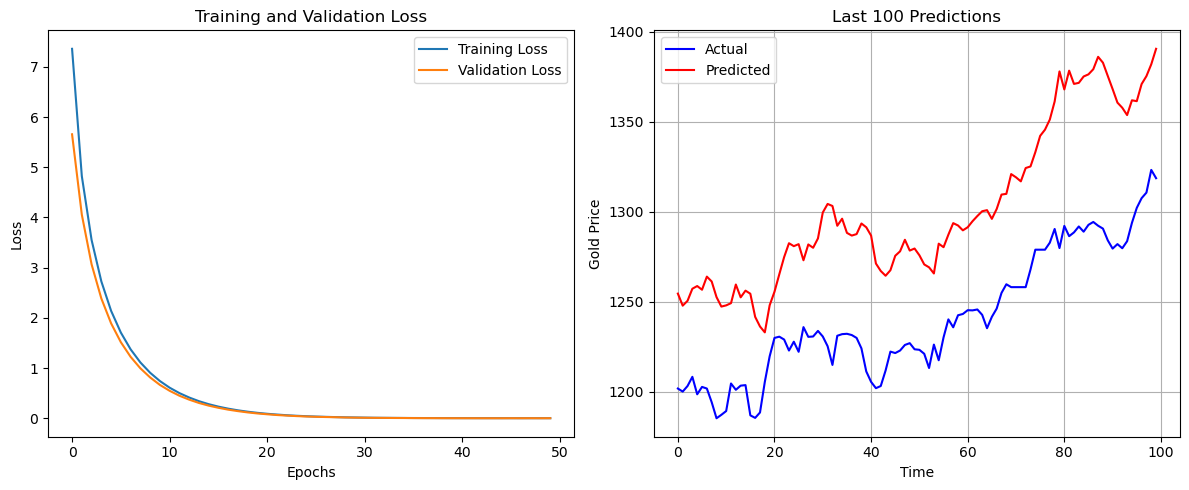


Visualizing attention over time...


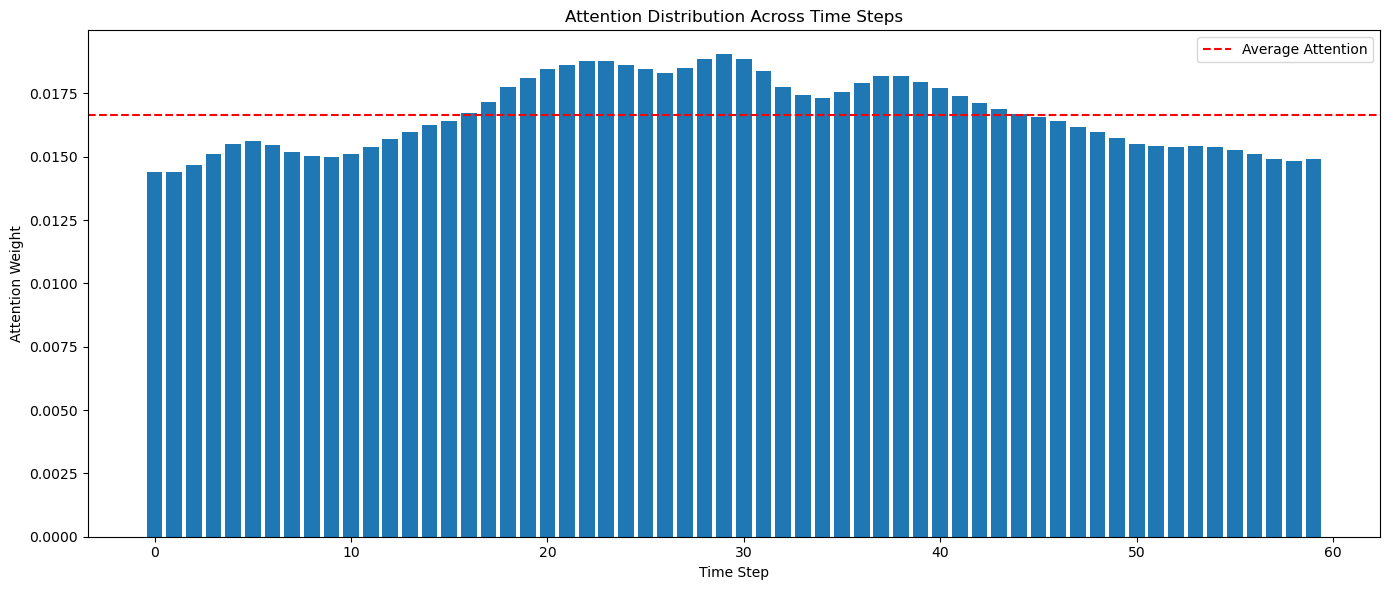

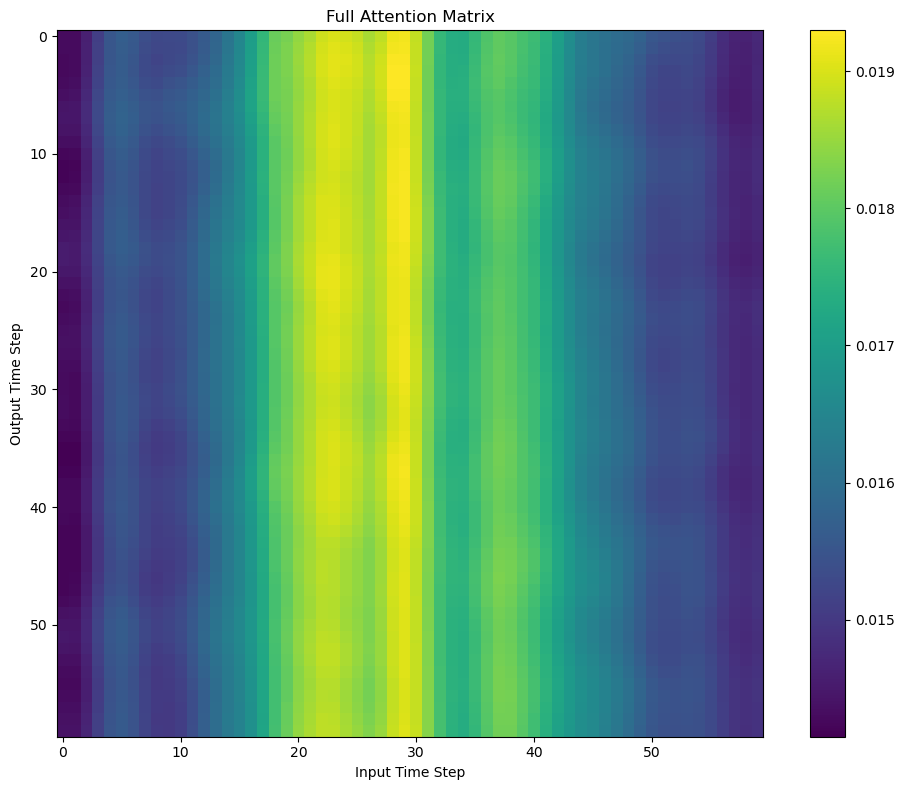


Running trading strategy backtest...


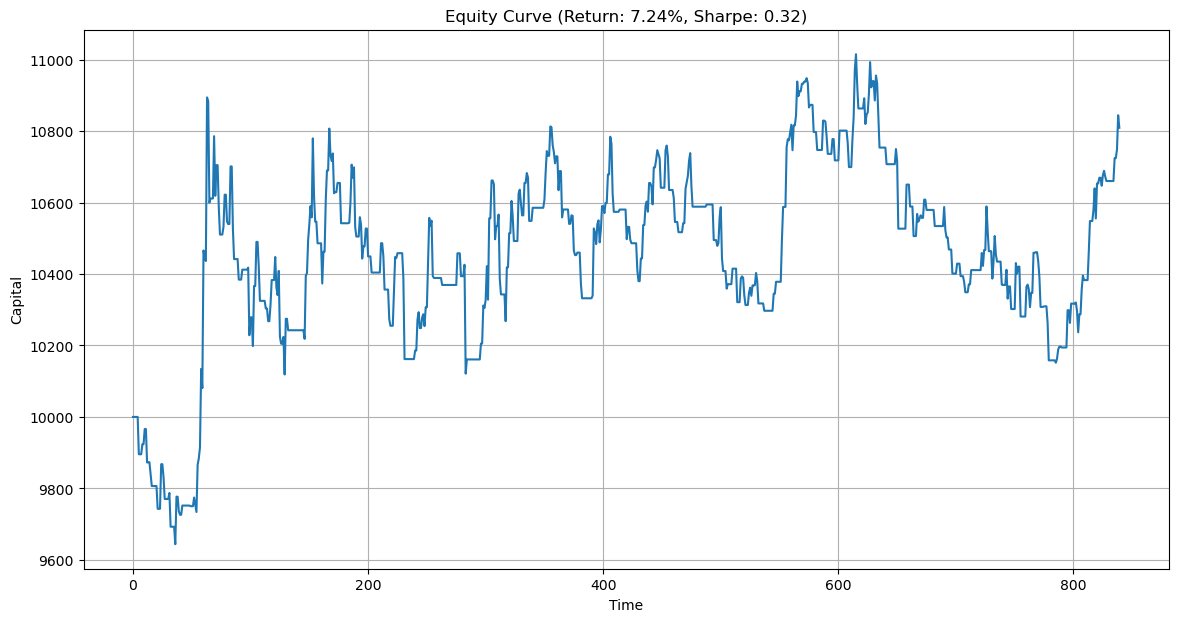

Final capital: $10724.35
Return: 7.24%
Sharpe Ratio: 0.32
Number of trades: 164


In [ ]:
import optuna
def tune_gold_price_model(df, features, seq_length=60, test_size=0.2, n_trials=20):
    """
    Hyperparameter tuning for gold price prediction model
    """
    # Prepare data once (outside the optimization loop)
    train_size = int(len(df) * (1 - test_size))
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size - seq_length:]
    
    if "Price" not in features:
        features.append("Price")
    
    train_data, scaler_dict, features = prepare_data(train_data, features)
    
    test_data_scaled = test_data[features].copy()
    for column in test_data_scaled.columns:
        test_data_scaled[column] = scaler_dict[column].transform(
            test_data_scaled[column].values.reshape(-1, 1)
        )
    
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data_scaled, seq_length)
    
    input_dim = X_train.shape[2]
    
    # Define optimization function with Optuna
    def objective(trial):
        # Define hyperparameters to tune
        params = {
            'd_model': trial.suggest_categorical('d_model', [64, 128, 256]),
            'num_heads': trial.suggest_int('num_heads', 2, 8, step=2),
            'num_layers': trial.suggest_int('num_layers', 2, 4),
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.4, step=0.1),
            'attention_decay_factor': trial.suggest_float('attention_decay_factor', 
                                                         0.0001, 0.0005, step=0.0001),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64]),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.005, log=True)
        }
        
        # Build model with trial params
        model = GoldPriceTransformer(
            input_dim=input_dim,
            output_dim=1,
            d_model=params['d_model'],
            num_heads=params['num_heads'],
            num_layers=params['num_layers'],
            dropout_rate=params['dropout_rate'],
            attention_decay_factor=params['attention_decay_factor']
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
            loss="mean_squared_error"
        )
        
        # Early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )
        
        # Train model
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            batch_size=params['batch_size'],
            epochs=30,  
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Return best validation loss
        return min(history.history['val_loss'])
    
    def print_trial_info(study, trial):
        print(f"\nTrial {trial.number} finished:")
        print(f"  Value: {trial.value:.4f}")
        print(f"  Params: {trial.params}")
        if study.best_trial.number == trial.number:
            print(f"  This is the best trial so far!")
        print(f"  Best value: {study.best_value:.4f}")
        print(f"  Best params: {study.best_params}\n")
    
    # Run optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, callbacks=[print_trial_info])
    
    # Get best parameters and train final model
    best_params = study.best_params
    print("Best parameters:", best_params)
    
    # Run your full training function with best parameters
    final_results = run_gold_price_backtesting(
        df=df,
        features=features,
        seq_length=seq_length,
        test_size=test_size,
        d_model=best_params['d_model'],
        num_heads=best_params['num_heads'],
        num_layers=best_params['num_layers'],
        dropout_rate=best_params['dropout_rate'],
        batch_size=best_params['batch_size'],
        epochs=50,
        attention_decay_factor=best_params['attention_decay_factor']
    )
    
    return {
        'best_params': best_params,
        'final_results': final_results
    }

best_params, fine_tuned_results = tune_gold_price_model(load_data(), ['Band_Spread', 'DFII10', 'RSI', 'Exponential_Weighted_Score', 'EMA30', 'EMA252'], seq_length=60, test_size=0.2, n_trials=30)

# Final Model

Training data shape: (3297, 60, 11)
Testing data shape: (840, 60, 11)
Epoch 1/30
83/83 [==============================] - 15s 85ms/step - loss: 7.2536 - val_loss: 5.6201
Epoch 2/30
83/83 [==============================] - 6s 67ms/step - loss: 4.7929 - val_loss: 4.0208
Epoch 3/30
83/83 [==============================] - 6s 68ms/step - loss: 3.5227 - val_loss: 3.0306
Epoch 4/30
83/83 [==============================] - 5s 64ms/step - loss: 2.6894 - val_loss: 2.3442
Epoch 5/30
83/83 [==============================] - 6s 68ms/step - loss: 2.0997 - val_loss: 1.8443
Epoch 6/30
83/83 [==============================] - 6s 69ms/step - loss: 1.6591 - val_loss: 1.4691
Epoch 7/30
83/83 [==============================] - 5s 63ms/step - loss: 1.3262 - val_loss: 1.1770
Epoch 8/30
83/83 [==============================] - 5s 66ms/step - loss: 1.0667 - val_loss: 0.9529
Epoch 9/30
83/83 [==============================] - 5s 62ms/step - loss: 0.8627 - val_loss: 0.7720
Epoch 10/30
83/83 [===================

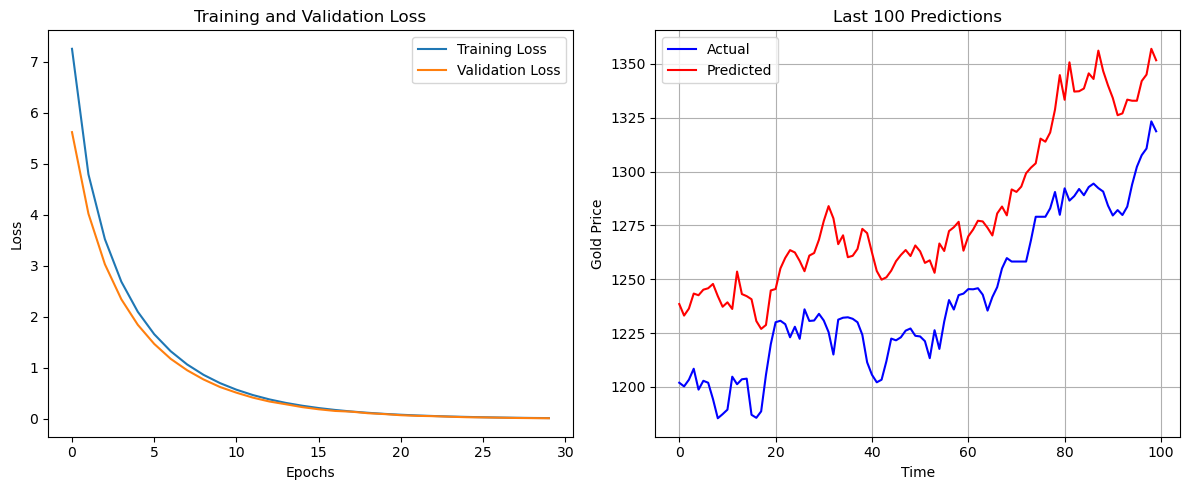


Analyzing feature importance...
27/27 [==============================] - 1s 23ms/step


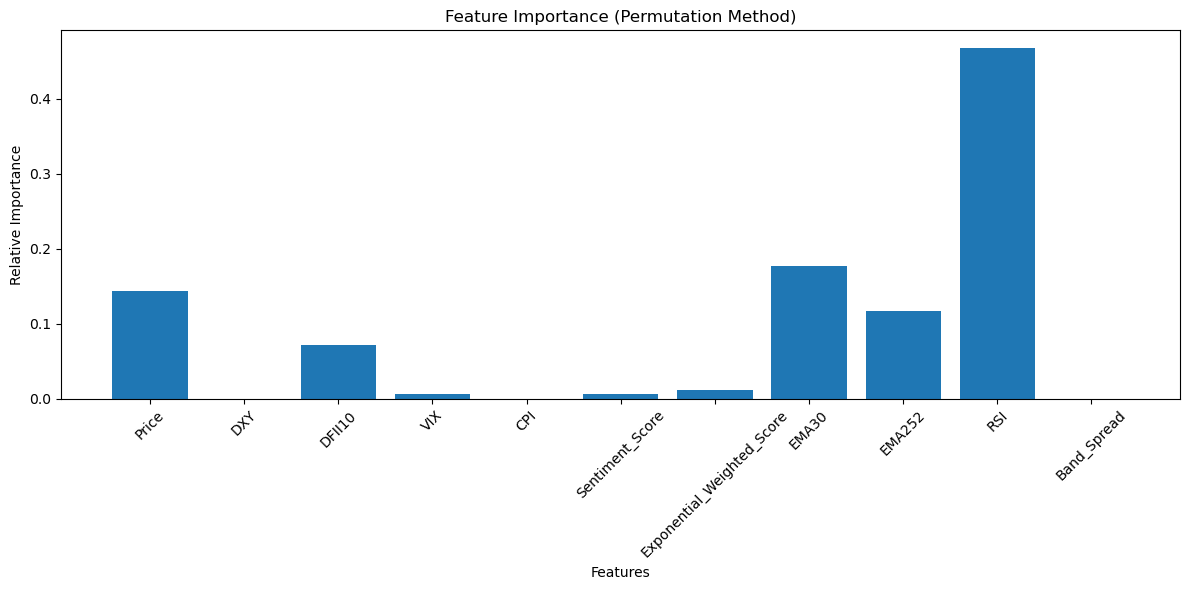


Visualizing attention over time...


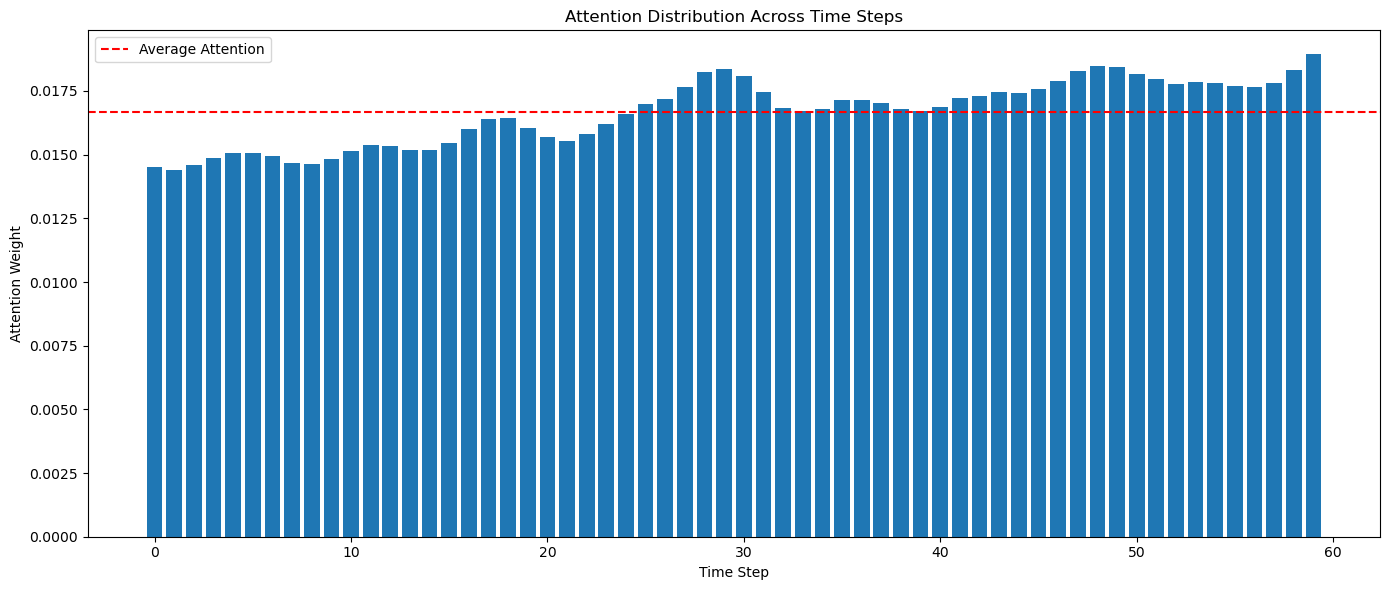

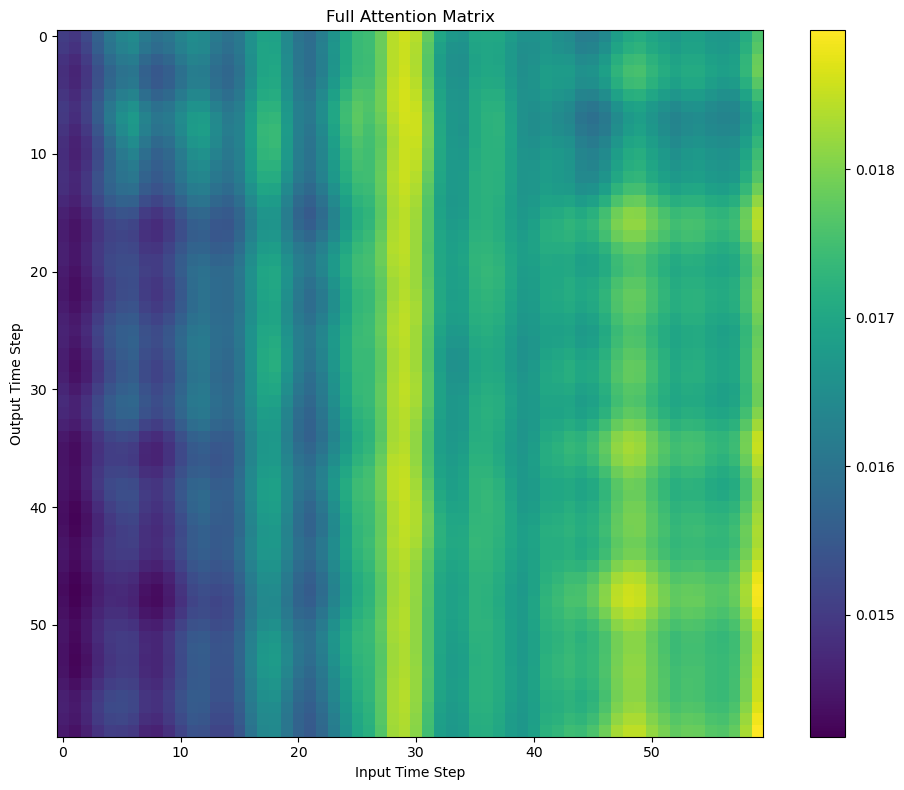


Running trading strategy backtest...


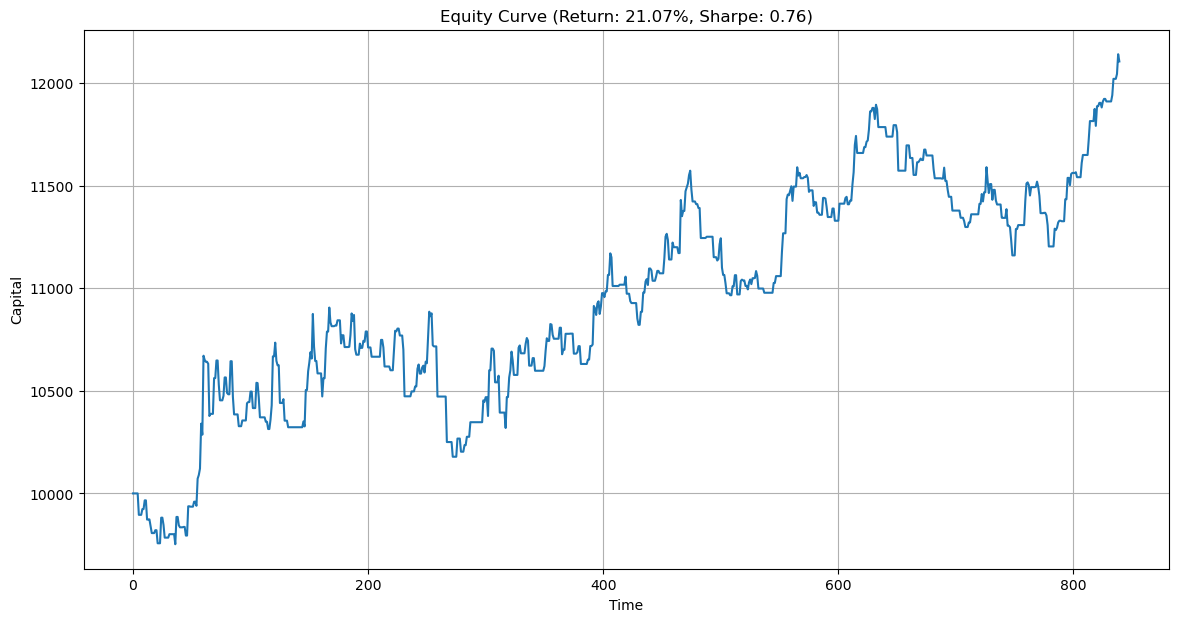

Final capital: $12106.58
Return: 21.07%
Sharpe Ratio: 0.76
Number of trades: 198


In [15]:
full_model_w_all_features = run_gold_price_backtesting(load_data(),
                                                       ['Price', 'DXY', 'DFII10', 'VIX', 'CPI', 'Sentiment_Score',
                                                        'Exponential_Weighted_Score', 'EMA30', 'EMA252', 'RSI', 'Band_Spread'], 
                                                       seq_length=60, 
                                                       test_size=0.2, 
                                                       d_model=64, 
                                                       num_heads=8, 
                                                       num_layers=4, 
                                                       dropout_rate=0.1, 
                                                       batch_size=32, 
                                                       epochs=30,
                                                       attention_decay_factor=0.0003)

# Load Pre-Trained Transformer

27/27 [==============================] - 1s 29ms/step


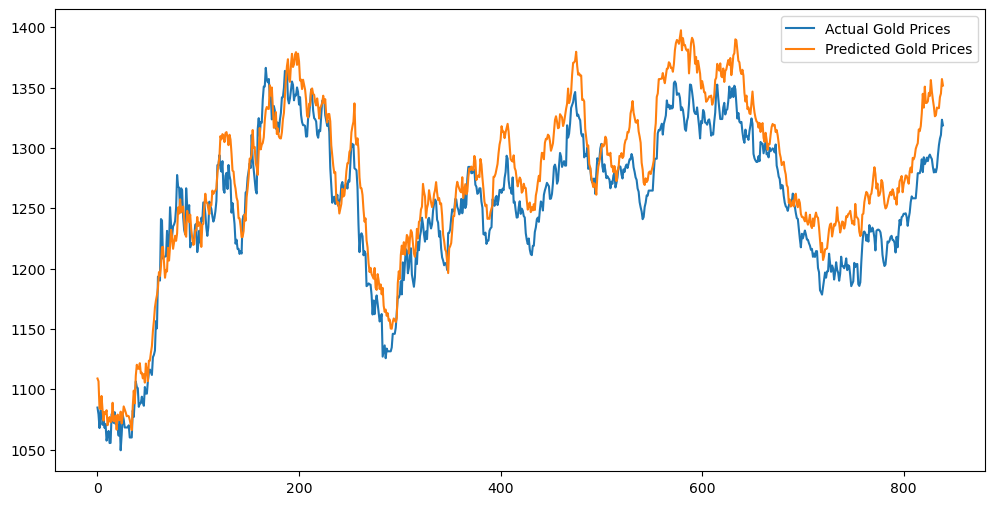

In [ ]:
df = load_data()
test_size = 0.2
seq_length = 60

# Split raw data first
train_size = int(len(df) * (1 - test_size))
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size - seq_length:]

features = ['Price', 'DXY', 'DFII10', 'VIX', 'CPI', 'Sentiment_Score', 'Exponential_Weighted_Score', 'EMA30', 'EMA252', 'RSI', 'Band_Spread']

# Prepare training data
if "Price" not in features:
    features.append("Price")
train_data, scaler_dict, features = prepare_data(train_data, features)
price_scaler = scaler_dict['Price']

# Apply the same scalers to test data
test_data_scaled = test_data[features].copy()
for column in test_data_scaled.columns:
    test_data_scaled[column] = scaler_dict[column].transform(
        test_data_scaled[column].values.reshape(-1, 1)
    )

# Create sequences for both sets
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data_scaled, seq_length)

loaded_model_all_features = keras.models.load_model(
    'gold_price_transformer_all_features'
)

# Evaluate on the test set
y_pred = loaded_model_all_features.predict(X_test)

# Denormalize predictions and actual values
y_test_denorm = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_denorm = price_scaler.inverse_transform(y_pred).flatten()

plt.figure(figsize = (12,6))
plt.plot(y_test_denorm, label = "Actual Gold Prices")
plt.plot(y_pred_denorm, label = "Predicted Gold Prices")
plt.legend()
plt.show()

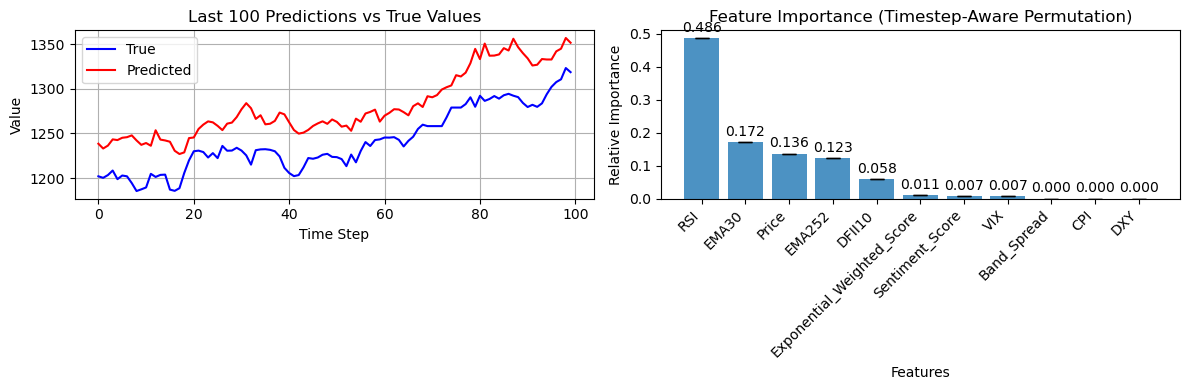

{'mean_importance': {'Price': 0.13604499042263365,
  'DXY': 0.0,
  'DFII10': 0.058229696350508446,
  'VIX': 0.006838421444620247,
  'CPI': 0.0,
  'Sentiment_Score': 0.007478330734441058,
  'Exponential_Weighted_Score': 0.010863657813676356,
  'EMA30': 0.17150959376885702,
  'EMA252': 0.12309289036634667,
  'RSI': 0.4859424190989166,
  'Band_Spread': 0.0},
 'std_importance': {'Price': 2.4133242728593562e-06,
  'DXY': 1.8464541969666673e-06,
  'DFII10': 2.3088984285742014e-06,
  'VIX': 6.290418769283069e-07,
  'CPI': 1.2541168659748774e-06,
  'Sentiment_Score': 1.3978110757415386e-06,
  'Exponential_Weighted_Score': 1.7908780121347872e-06,
  'EMA30': 4.809032840084659e-06,
  'EMA252': 1.7699503428790858e-06,
  'RSI': 1.129519729721771e-05,
  'Band_Spread': 1.2394889553280785e-06},
 'baseline_error': 0.00033603556096770766,
 'method': 'timestep_aware'}

In [ ]:
analyze_feature_importance(loaded_model_all_features, X_test, y_test, ['Price', 'DXY', 'DFII10', 'VIX', 'CPI', 'Sentiment_Score', 'Exponential_Weighted_Score', 'EMA30', 'EMA252', 'RSI', 'Band_Spread'], 
                            batch_size=None, 
                            n_repeats=5,
                            normalize=True,
                            show_plot=True,
                            figure_size=(12, 4),
                            sort_features=True)